# Examen visión computacional
---

## Instrucciones
---

1. Revisa el dataset que se incluye en las celdas siguientes.
2. En base a este, crea un clasificador que pueda decir el tipo de coche y su color.
3. Llena las celdas de código como se va solicitando.
4. Al terminar, sube el notebook con todas las celdas ejecutadas a canvas.

## Imports

In [ ]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

import os

## Descarga del dataset

In [ ]:
!rm -r cars
!rm cars_multilabel.zip
!curl -L -o ./cars_multilabel.zip https://www.kaggle.com/api/v1/datasets/download/julichitai/multilabel-small-car-and-color-dataset
!unzip -d cars cars_multilabel.zip > /dev/null

rm: cannot remove 'cars': No such file or directory
rm: cannot remove 'cars_multilabel.zip': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  240M  100  240M    0     0   131M      0  0:00:01  0:00:01 --:--:--  186M


In [ ]:
!ls cars

'matiz black'  'matiz red'  'rio blue'	'tiggo black'  'tiggo red'
'matiz blue'   'rio black'  'rio red'	'tiggo blue'


In [ ]:
!ls cars/matiz\ black

000001.jpg				      2a0000017a0a9cf8af0cc089f4766d96f1ea.png
000002.jpg				      2a0000017a0cc9c0e49d437fa30725744c27.png
000003.jpg				      2a0000017a0e7b63e8158ba07e8b346bbe79.png
000004.jpg				      2a0000017a193885652f06b4edf4bd95e197.png
000005.jpg				      2a884d73e53b56fbbc2cea45eb281776.png
000006.jpg				      2ae07662150bd52cf9c702bd63cdd629.png
000007.jpg				      2c2bbe596a3cb0e37d32a5f4338ef5b2e61810a1.png
000008.jpg				      2d000d5899bfe225fccdd1cb32a46318_sr.png
000009.jpg				      2d31b1411357835256d01d14bd00bb2e13b1b660.png
000010.jpg				      2d78db60d1e46a087f6a4e174e349bfda5ab5524.png
000011.jpg				      31edbeeb90b87266abaf54c7b227f52c4fe59713.png
000012.jpg				      33e78b416574915f162866c795b0436ade360285.png
000013.jpg				      3498bd8106da059df1bd99e234b13a9d70d4fcd2.png
000014.jpg				      39d86724b0fb446ee8e61f9fe2882086dae735c1.png
000015.jpg				      3a92939b32afd6f469a3aecc79e5f1c03ca1d157.png
000016.jpg				      3b027cca1df1a7806c07881650cc16d5cdddc8bb.p

## Visualización de imágenes **(5 puntos)**
---

**TO DO**: Visualiza una imagen de cada clase.

In [ ]:
# Define the path to your dataset
dataset_path = 'cars'

# Get a list of all the subfolders (classes) in the dataset
classes = os.listdir(dataset_path)

# Iterate through each class and display one image
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)

    # Get a list of image files in the class folder
    image_files = os.listdir(class_path)

    # Check if there are any images in the folder
    if image_files:
        # Get the path to the first image in the folder
        image_path = os.path.join(class_path, image_files[0])

        # Read and display the image using OpenCV and Matplotlib
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        plt.figure()
        plt.title(class_name)
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels
        plt.show()
    else:
        print(f"No hay clase: {class_name}")

Output hidden; open in https://colab.research.google.com to view.

## Carga de imágenes en dataloaders **(15 puntos)**
---

**TO DO**: Construye los dataloaders necesarios, con las transformaciónes adecuadas, y muestra un batch. Connstruye las etiquetas de las imágenes para poder hacer clasificación multi-etiqueta.

In [ ]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

# Define the dataset path
dataset_path = 'cars'

# Create a custom dataset class for multi-label classification
class MultiLabelDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}  # Create class-to-index mapping
        self.targets = [self._get_multi_label_target(p) for p in self.imgs]

    def _get_multi_label_target(self, path):
        # Example: path = 'cars/matiz black/image.jpg'
        parts = path[0].split('/')  # Split path into parts ['cars', 'matiz black', 'image.jpg']
        labels = parts[1].split()  # Extract labels ['matiz', 'black']
        label_indices = [self.class_to_idx[label] for label in labels if label in self.class_to_idx]  # Map labels to indices
        target = torch.zeros(len(self.classes), dtype=torch.float32)  # Create a multi-hot target vector
        target[label_indices] = 1  # Set 1 for the corresponding labels
        return target

    def __getitem__(self, index):
        image, _ = super().__getitem__(index)  # Get image using parent class
        target = self.targets[index]  # Get multi-label target
        return image, target

# Create the dataset
dataset = MultiLabelDataset(dataset_path, transform=data_transforms)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Display a batch of images and labels
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)  # Print the shapes of images and labels

torch.Size([32, 3, 224, 224]) torch.Size([32, 9])


In [ ]:
# Data Loading and Transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('cars', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

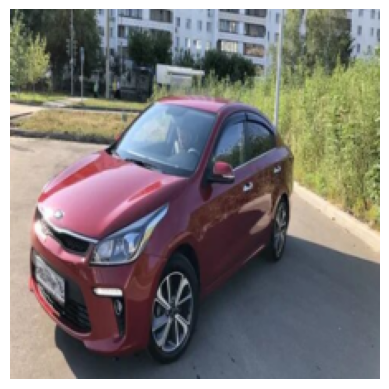

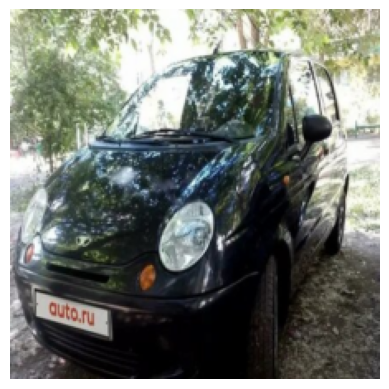

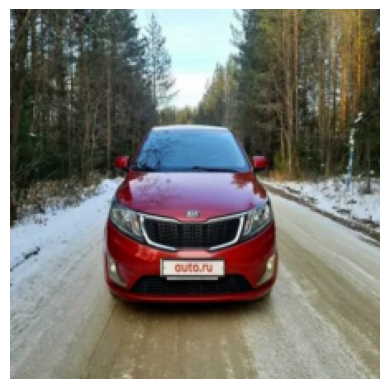

In [ ]:
# Display images and their labels
num_images_to_display = 3

for i in range(min(num_images_to_display, images.shape[0])):
    image = images[i].permute(1, 2, 0)  # Permute dimensions to (H, W, C) for display
    image = image.numpy()  # Convert to NumPy array
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Un-normalize
    image = np.clip(image, 0, 1)  # Clip values to be in the range [0, 1]

    label_indices = torch.where(labels[i] == 1)[0]  # Get indices of labels with value 1
    label_names = [dataset.classes[idx] for idx in label_indices]  # Get label names from indices

    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Definición del modelo **(15 puntos)**
---

**TO DO**: Crea un modelo con capas convolucionales para hacer la clasificación.

In [ ]:
class MultiLabelCNN_Simplified(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelCNN_Simplified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 56 * 56, 12),  # Output layer directly to 12 classes
            nn.Sigmoid()  # Apply sigmoid for multi-label probabilities
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
num_classes = len(dataset.classes)  # Get the number of classes from your dataset
model = MultiLabelCNN_Simplified(num_classes)

In [ ]:
# Model Definition (Using a pre-trained model for faster training)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [ ]:
# Split the dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Entrenamiento **(5 puntos)**
---

**TO DO**: Entrena el modelo, y muestra los resultados de validación y entrenamiento.

In [ ]:
from torch.optim import AdamW

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    criterion = nn.BCELoss()  # Use Binary Cross Entropy Loss for multi-label classification
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [ ]:
num_epochs = 10
learning_rate = 0.001
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate)

Epoch [1/10], Train Loss: 0.0101, Val Loss: 0.0000
Epoch [2/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [3/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [4/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [5/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [6/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/10], Train Loss: 0.0158, Val Loss: 0.0000
Epoch [10/10], Train Loss: 0.0512, Val Loss: 0.0000


In [ ]:
# Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # Reduced for faster training

for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.6637
Epoch [2/5], Loss: 0.1735
Epoch [3/5], Loss: 0.6583
Epoch [4/5], Loss: 0.0351
Epoch [5/5], Loss: 0.0649


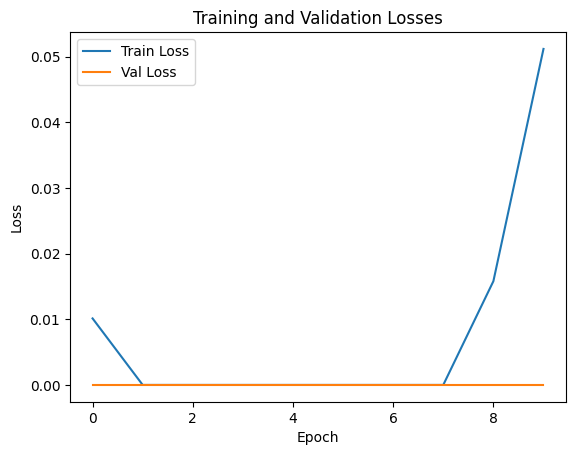

In [ ]:
# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

## Pruebas **(5 puntos)**
---

**TO DO**: Prueba el desempeño de tu modelo con datos de prueba.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            # Applying threshold to predictions
            _, predictions = torch.max(outputs, 1) # Get the class with highest probability
            all_predictions.append(predictions)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    all_predictions = all_predictions.cpu().numpy()
    all_labels = all_labels.cpu().numpy()

    # Convert predictions to one-hot encoding if labels are in multilabel-indicator format
    if all_labels.ndim == 2 and all_labels.shape[1] > 1:  # Check if labels are multilabel-indicator
        from sklearn.preprocessing import LabelBinarizer
        lb = LabelBinarizer()
        lb.fit(range(all_labels.shape[1]))  # Fit to the number of classes
        all_predictions = lb.transform(all_predictions)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    f1 = f1_score(all_labels, all_predictions, average='micro')

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    return accuracy, precision, recall, f1

In [ ]:
accuracy, precision, recall, f1 = evaluate_model(model, val_loader)

Accuracy: 0.07
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on validation set: {accuracy:.2f}%')
    return accuracy

In [ ]:
# Evaluate the model
accuracy = evaluate_model(model, val_loader)

RuntimeError: The size of tensor a (32) must match the size of tensor b (9) at non-singleton dimension 1

## Predicción **(5 puntos)**
---

**TO DO**: Descarga una imagen, y haz una predicción sobre ella. Usa wget como en el siguiente ejemplo.

In [ ]:
!wget -O matiz_rojo.jpg https://i.pinimg.com/736x/83/90/e7/8390e7fb457d2b87f98483982ebe4a62.jpg

--2024-11-06 02:32:57--  https://i.pinimg.com/736x/83/90/e7/8390e7fb457d2b87f98483982ebe4a62.jpg
Resolving i.pinimg.com (i.pinimg.com)... 173.223.234.198, 173.223.234.207, 2a04:4e42::84, ...
Connecting to i.pinimg.com (i.pinimg.com)|173.223.234.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44979 (44K) [image/jpeg]
Saving to: ‘matiz_rojo.jpg’

matiz_rojo.jpg      100%[===================>]  43.92K  --.-KB/s    in 0.007s  

2024-11-06 02:32:57 (5.75 MB/s) - ‘matiz_rojo.jpg’ saved [44979/44979]



https://images.app.goo.gl/2jQ6ihshzHwmwM1j9

https://images.app.goo.gl/rvcr38SzCtsmt2xa9

https://images.app.goo.gl/BXoPLY9yREFFusgs7

https://images.app.goo.gl/QrdcSbeJuHokp18K7

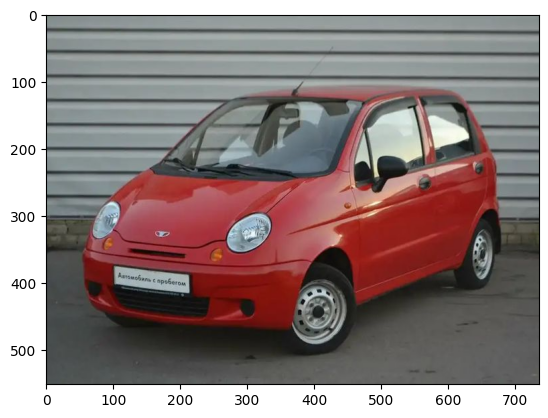

In [ ]:
image = cv2.imread('matiz_rojo.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [ ]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Define transformations for the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load and preprocess an image from a URL
def load_image_from_url(image_url):
    response = requests.get(image_url, stream=True)
    response.raise_for_status()  # Raise an exception if the download fails
    image = Image.open(BytesIO(response.content)).convert('RGB')  # Ensure RGB format
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Image URLs from your links
image_urls = [
    "https://i.pinimg.com/736x/83/90/e7/8390e7fb457d2b87f98483982ebe4a62.jpg",
    "https://images.app.goo.gl/2jQ6ihshzHwmwM1j9",
    "https://images.app.goo.gl/rvcr38SzCtsmt2xa9",
    "https://images.app.goo.gl/BXoPLY9yREFFusgs7",
    "https://images.app.goo.gl/QrdcSbeJuHokp18K7"
]

# Make predictions for each image
for url in image_urls:
    image = load_image_from_url(url)

    with torch.no_grad():
        output = model(image)

    # Process the output (e.g., get the predicted class)
    _, prediction = torch.max(output, 1)
    predicted_class_index = prediction.item()
    predicted_class_name = dataset.classes[predicted_class_index]  # Assuming you have access to 'dataset'

    print(f"Predicted class for {url}: {predicted_class_name}")

Predicted class for https://i.pinimg.com/736x/83/90/e7/8390e7fb457d2b87f98483982ebe4a62.jpg: matiz red


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7c092e89f3d0>